Luke Wanner

Notebook summarizing resonance fitting for Microwave multiplexers using code provided by Ben Mates at NIST.

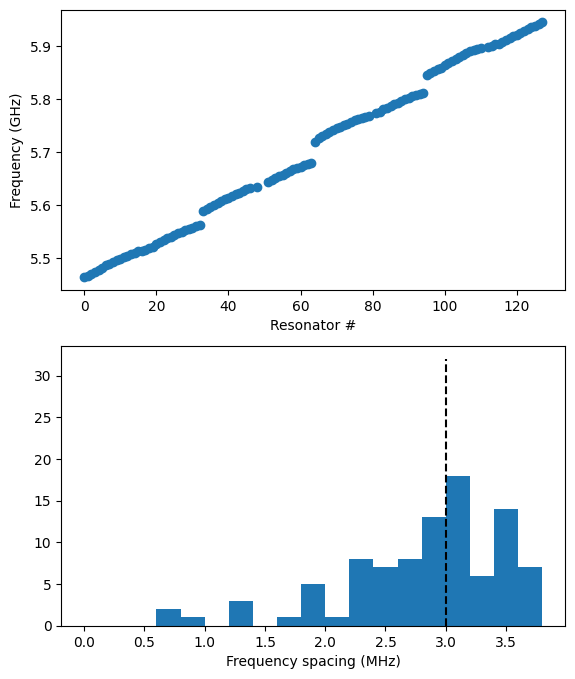

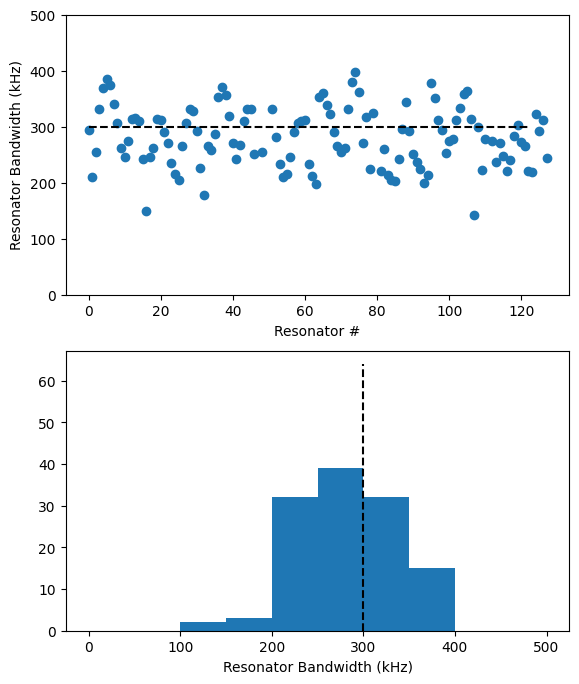

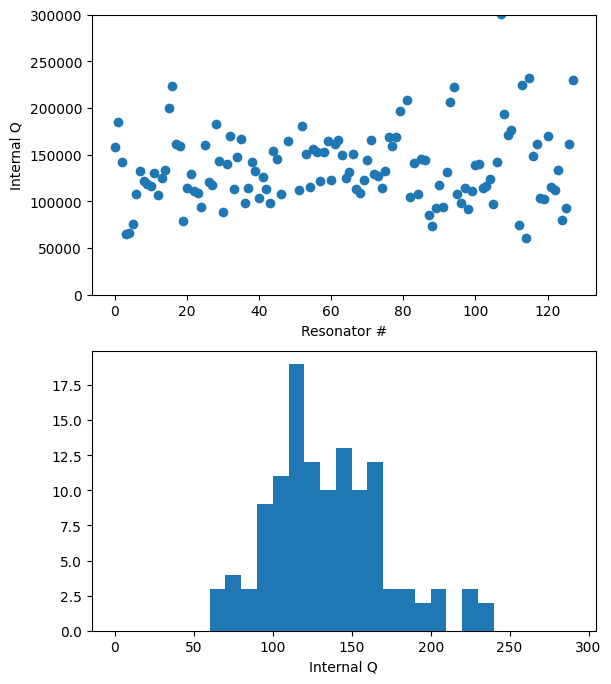

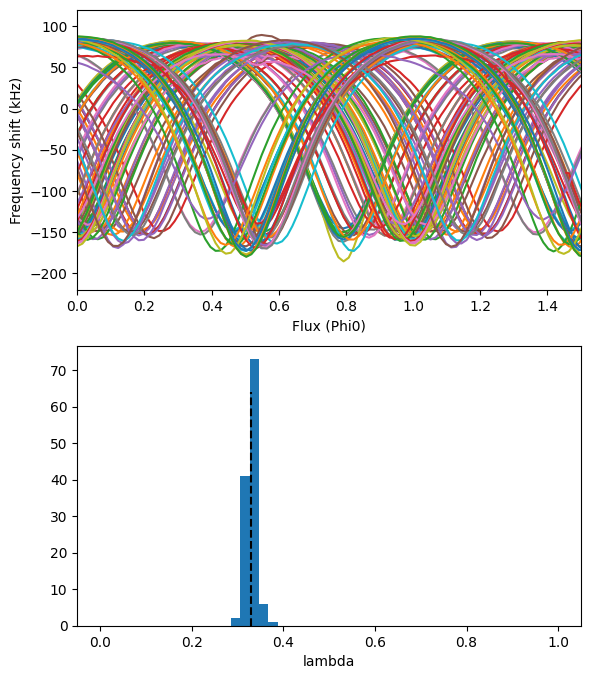

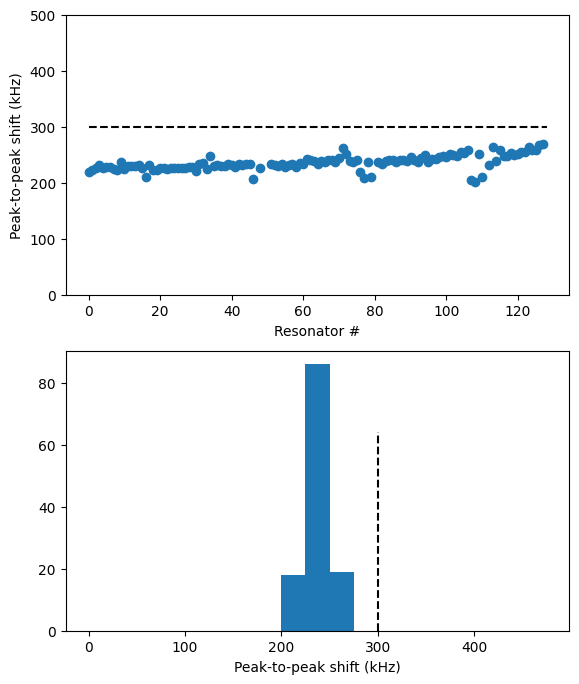

Resonator spacing 		= 3.942810 +/- 4.856164 MHz
Resonator bandwidth 		= 281.029541 +/- 52.509810 kHz
Resonator frequency shift 	= 235.966712 +/- 12.985463 kHz
Resonator internal Q 		= 135.785444 +/- 39.122392 thousand
SQUID lambda 			= 0.331629 +/- 0.011689


In [2]:
import numpy as np
import fitresonance as fr
import lambdafit as lf

import matplotlib.pyplot as plt
plt.ion()

filename = "frsurvey_umux300k_v6_w1_20220825.npz"

###########################################################################################
# When we take a flux-ramp survey we should save at least the following variables:
#   f_wide      : Frequencies in wide VNA sweep (Hz).                           (l)
#   s21_wide    : Complex S21 values from wide VNA sweep.                       (l)
#   fc          : Center frequencies for the flux-ramp survey (Hz).             (n)
#   ibias       : Bias current values applied to the flux-ramp coil (A).        (m)
#   fbias       : Frequency offsets in VNA sweeps for flux-ramp survey (Hz).    (p)
#   s21_fr      : Complex S21 values from flux-ramp survey sweeps.          (n x m x p)
data = np.load(filename)
f_wide = data['f_wide']
s21_wide = data['s21_wide']
fc = data['fc']
ibias = data['ibias']
fbias = data['fbias']
s21_fr = data['s21_fr']
tau = data['tau']

# Exclude bad resonances from the fitting procedure
#bad = np.array([],dtype=int)
bad = np.array([47,49,50,80,111])
good = np.array([],dtype=int)
for n in range(len(fc)):
    if n not in bad:
        good = np.append(good,n)


# Fit resonances
f0fits = np.zeros((len(good),len(ibias)))
Qcfits = np.zeros((len(good),len(ibias)))
Qifits = np.zeros((len(good),len(ibias)))
for n in range(len(good)):
    #print("Fitting resonator index {:d}".format(good[n]))
    for m in range(len(ibias)):
        ftemp = fc[good[n]] + fbias
        s21temp = s21_fr[good[n],m,:]
        f0fits[n,m],Qcfits[n,m],Qifits[n,m] = fr.fit_resonance(ftemp,s21temp,showplot=False)

# Fit SQUID parameters
I0fits = np.zeros(len(good))
Minfits = np.zeros(len(good))
Mcfits = np.zeros(len(good))
fbfits = np.zeros(len(good))
lambfits = np.zeros(len(good))
for n in range(len(good)):
    I0fits[n],Minfits[n],Mcfits[n],fbfits[n],lambfits[n] = lf.fit_lambda(ibias,f0fits[n,:],showplot=False)






# Plot frequency distribution
plt.figure(100,figsize=(6.5,8))
plt.subplot(2,1,1)
plt.plot(good,np.mean(f0fits,axis=1)/1e9,'o')
plt.xlabel('Resonator #')
plt.ylabel('Frequency (GHz)')
plt.subplot(2,1,2)
plt.hist(np.diff(np.mean(f0fits,axis=1))/1e6,bins=np.arange(0.0,4.0,0.2))
plt.plot(np.ones(2)*3.0,np.array([0,32]),'--k')
plt.xlabel('Frequency spacing (MHz)')

# Plot bandwidth distribution
Qfits = 1 / (1/np.mean(Qifits,axis=1) + 1/np.mean(Qcfits,axis=1))
BWfits = np.mean(f0fits,axis=1) / Qfits

plt.figure(200,figsize=(6.5,8))
plt.subplot(2,1,1)
plt.plot(good,BWfits/1e3,'o')
plt.plot(np.array([0,len(BWfits)-1]),np.ones(2)*300.0,'--k')
plt.ylim(0,500)
plt.xlabel('Resonator #')
plt.ylabel('Resonator Bandwidth (kHz)')
plt.subplot(2,1,2)
plt.hist(BWfits/1e3,bins=np.arange(0,501,50))
plt.plot(np.ones(2)*300.0,np.array([0,64]),'--k')
plt.xlabel('Resonator Bandwidth (kHz)')

# Plot Qi distribution
plt.figure(300,figsize=(6.5,8))
plt.subplot(2,1,1)
plt.plot(good,np.mean(Qifits,axis=1),'o')
plt.xlabel('Resonator #')
plt.ylabel('Internal Q')
plt.ylim(0,300e3)
plt.subplot(2,1,2)
plt.hist(np.mean(Qifits,axis=1)/1e3,bins=np.arange(0,300,10))
plt.xlabel('Internal Q')

# Plot lambda distribution
Mm = np.mean(Minfits)
plt.figure(400,figsize=(6.5,8))
plt.subplot(2,1,1)
plt.plot(ibias*Mm/2.068e-15,np.transpose(f0fits-np.outer(fbfits,np.ones(len(ibias))))/1e3)
plt.xlim(0,1.5)
plt.xlabel('Flux (Phi0)')
plt.ylim(-220,120)
plt.ylabel('Frequency shift (kHz)')
plt.subplot(2,1,2)
plt.hist(lambfits,bins=np.linspace(0,1,50))
plt.plot(np.ones(2)*0.33,np.array([0,64]),'--k')
plt.xlabel('lambda')

# Plot frequency shift distribution
Z0 = 50.0
Ls = 22.4e-12           # From FastHenry inductance simulation
fppfits = (4*fbfits**2)/Z0 * (Mcfits**2 / Ls) * (2*lambfits/(1-(lambfits**2)))
plt.figure(500,figsize=(6.5,8))
plt.subplot(2,1,1)
plt.plot(good,fppfits/1e3,'o')
plt.plot(np.array([0,len(fc)]),np.ones(2)*300.0,'--k')
plt.ylim(0,500)
plt.xlabel('Resonator #')
plt.ylabel('Peak-to-peak shift (kHz)')
plt.subplot(2,1,2)
plt.hist(fppfits/1e3,bins=np.arange(0,500,25))
plt.plot(np.ones(2)*300.0,np.array([0,64]),'--k')
plt.xlabel('Peak-to-peak shift (kHz)')
plt.show()

print('Resonator spacing \t\t= {:f} +/- {:f} MHz'.format(np.mean(np.diff(np.mean(f0fits,axis=1)))/1e6,np.std(np.diff(np.mean(f0fits,axis=1)))/1e6))
print('Resonator bandwidth \t\t= {:f} +/- {:f} kHz'.format(np.mean(BWfits)/1e3,np.std(BWfits)/1e3))
print('Resonator frequency shift \t= {:f} +/- {:f} kHz'.format(np.mean(fppfits)/1e3,np.std(fppfits)/1e3))
print('Resonator internal Q \t\t= {:f} +/- {:f} thousand'.format(np.mean(np.mean(Qifits,axis=1))/1e3,np.std(np.mean(Qifits,axis=1))/1e3))
print('SQUID lambda \t\t\t= {:f} +/- {:f}'.format(np.mean(lambfits),np.std(lambfits)))


Single Resonance

f0 =  5.603981658146998 GHz


/Users/lukewanner/miniconda3/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/lukewanner/miniconda3/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


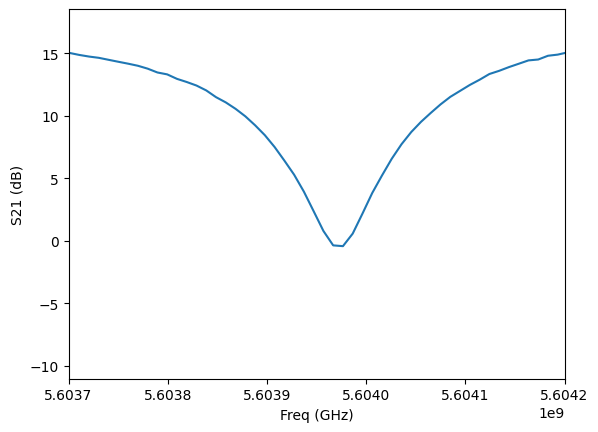

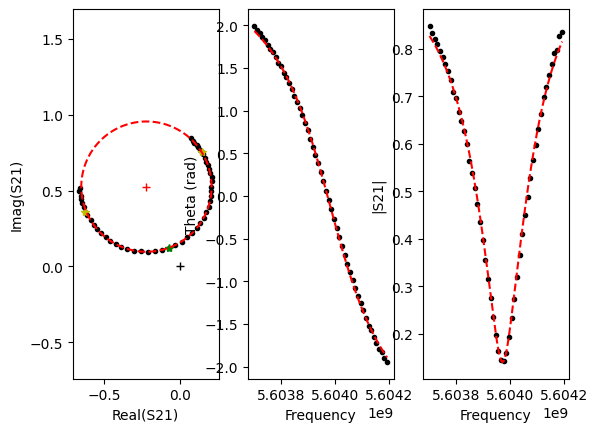

In [3]:


f_min = 5.6037e9
f_max = 5.6042e9

plt.plot(f_wide, 20*np.log10(s21_wide))
plt.xlim((f_min, f_max))
plt.ylabel("S21 (dB)")
plt.xlabel("Freq (GHz)")

mask = (f_wide >= f_min) & (f_wide <= f_max)
f_region = f_wide[mask]
s21_region = s21_wide[mask]

f0fit,Qcfit,Qifit = fr.fit_resonance(f_region, s21_region, showplot=True)
print("f0 = ", f0fit/1e9, "GHz")


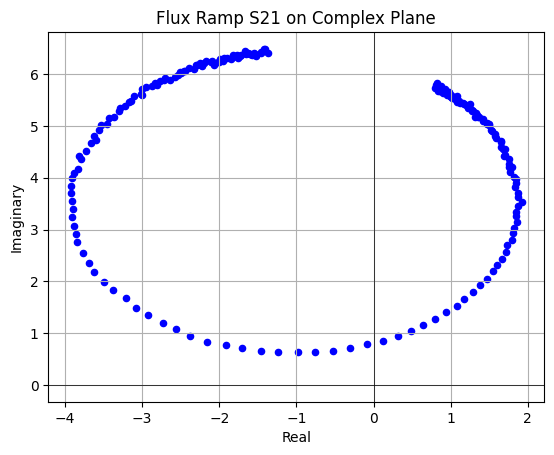

In [4]:
import matplotlib.pyplot as plt

# Assuming s21_fr is a numpy array of complex numbers
x = s21_fr.real[0][0]
y = s21_fr.imag[0][0]

plt.figure()
plt.scatter(x, y, color="blue", s=20)
plt.axhline(0, color="black", linewidth=0.5)  # real axis
plt.axvline(0, color="black", linewidth=0.5)  # imag axis
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Flux Ramp S21 on Complex Plane")
plt.grid(True)
plt.show()
